In [1]:
from functions import *
from random import sample
from htmldate import find_date
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
import json
from langid.langid import LanguageIdentifier, model
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import datefinder
import random
import re
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import networkx as nx
from pylab import *


/home/ruben/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
base_path = "/media/ruben/Data Drive/react-data/protest/{}".format("carlo")

In [5]:
# Import Texts

df = dict()
for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    num_iterations = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    num_iterations = len(num_iterations)

    start_iter = 1
    range_iter = [str(i) for i in list(range(1,num_iterations + 1))]
    
    photo_dict = dict()
    
    for it in range_iter:
        fn = os.path.join(photo_folder, photo + "_" + it, "txt", "parsed_text.json")
        with open(fn) as fp:
            t = json.load(fp)
            df.update({photo:t})

In [6]:
# Find Dates in Text

dates = dict()

for photo,items1 in df.items():
    
    dates.update({photo:dict()})
    
    for id_,sentences in items1.items():
        
        matches = []
        for sen in sentences:
            try:
                matches_sen = datefinder.find_dates(sen)
                matches_sen = [m for m in matches_sen if len(str(m.year)) == 4 and int(m.year) > 1900 and int(m.year) < 2020]
                matches += matches_sen
            except Exception as e:
                continue
        dates[photo].update({id_:matches})

/home/ruben/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [7]:
# Import Publication Dates

dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

In [8]:
# To DataFrame

resdf = pd.DataFrame()

for photo,items1 in dates.items():
    
    for id_,text_dates in items1.items():
        if len(text_dates) == 0:
            continue
        years = [d.year for d in text_dates]
        years = dict(Counter(years))
        years = pd.DataFrame(list(years.items()))
        years['id_'] = id_.split(".html_")[-1]
        
        if id_.split(".html_")[-1] in dates_ref.keys():
            pub_date = dates_ref[id_.split(".html_")[-1]][0:4]
            years['pub_date'] = pub_date
            resdf = resdf.append(years)

resdf.columns = ["ref_date","count","id_","pub_date"]
resdf2 = resdf[['pub_date','ref_date','count']]
resdf2 = resdf2.groupby(['ref_date','pub_date']).sum().reset_index()
resdf2 = resdf2[resdf2['ref_date'] > 2000]

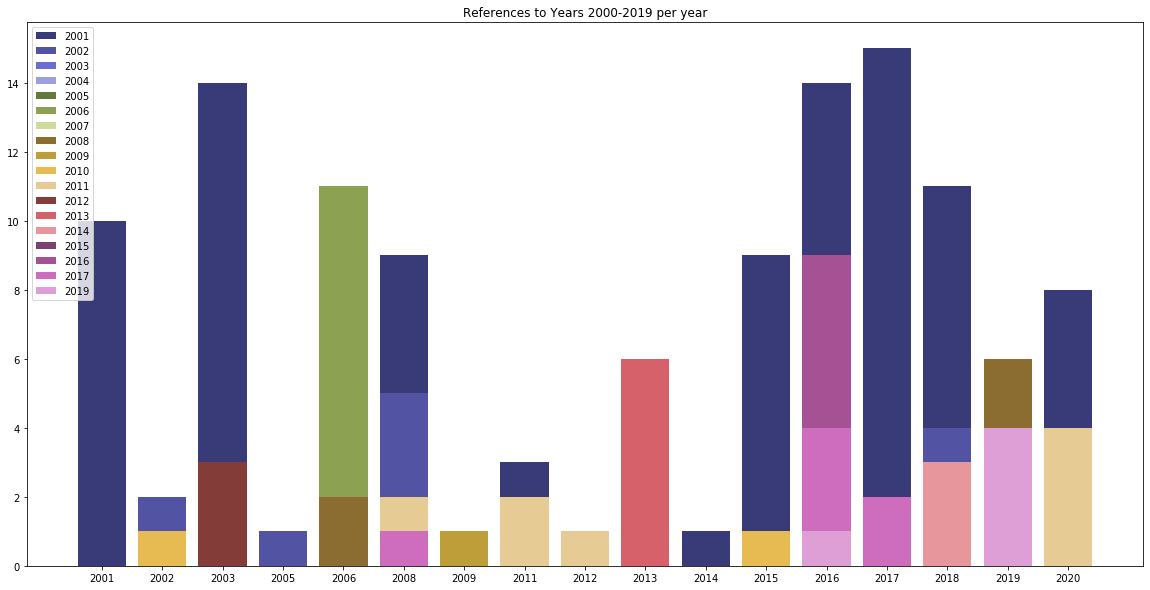

In [10]:
resdf2p = resdf2.pivot(index='pub_date',columns='ref_date',values='count').reset_index()

cmap = cm.get_cmap('tab20b', len(list(resdf2p.columns)[1:]))    # PiYG
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

plt.figure(figsize=(20, 10))

for c,ref_year in enumerate(list(resdf2p.columns)[1:]):
    plt.bar(list(resdf2p['pub_date']), list(resdf2p[ref_year]), color=colors[c])

plt.legend(list(resdf2p.columns)[1:], loc='upper left')
plt.title("References to Years 2000-2019 per year")
plt.savefig('allyears-references-year.png')
plt.show()

In [ ]:
# Plot Heatmap

resdf2p = resdf2.pivot(index='pub_date',columns='ref_date',values='count')

fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(20,10))
heatplot = ax.imshow(resdf2p, cmap='GnBu')
ax.set_xticklabels(resdf2p.columns)
ax.set_yticklabels(resdf2p.index)

tick_spacing = 1.02
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.ylabel('Years of Publication')
plt.xlabel('Referenced Years')


plt.show()

In [158]:
dfp2 = df_dates.pivot(index="year",columns="photo",values="count").reset_index()

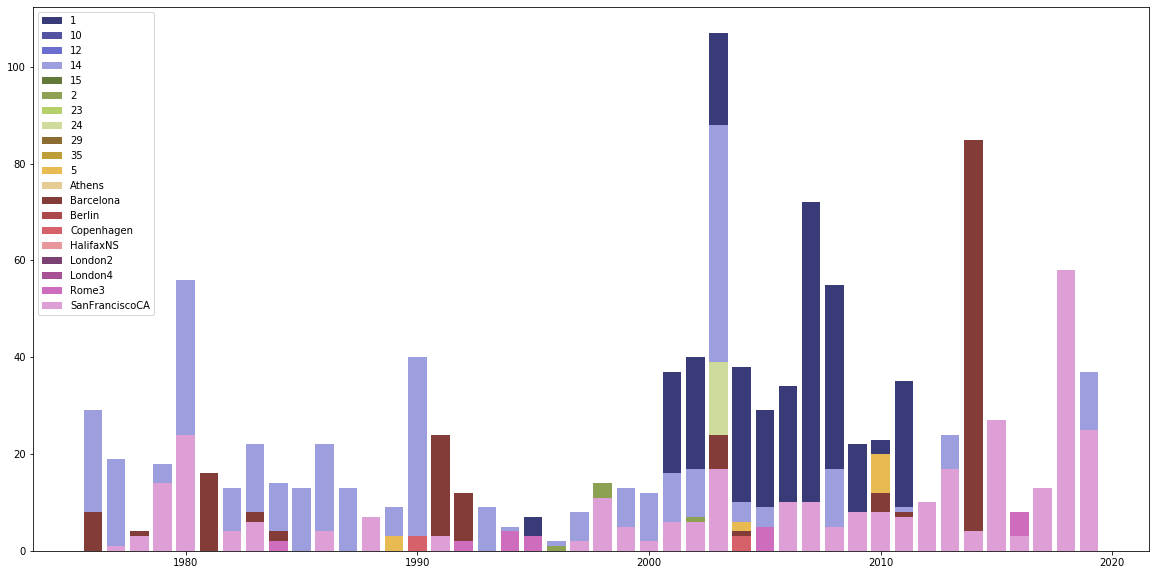

In [164]:
from pylab import *

cmap = cm.get_cmap('tab20b', len(list(dfp2.columns)[1:]))    # PiYG
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

plt.figure(figsize=(20, 10))

for c,city in enumerate(list(dfp2.columns)[1:]):
    plt.bar(list(dfp2['year']), list(dfp2[city]), color=colors[c])

plt.legend(list(dfp2.columns)[1:], loc='upper left')
plt.show()

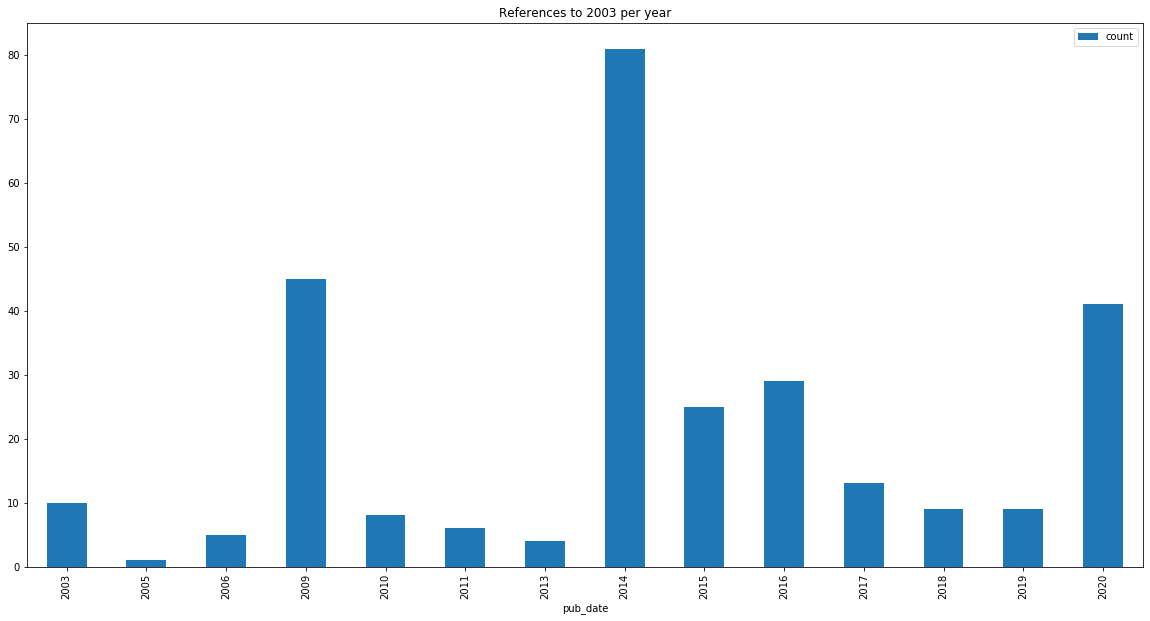

In [30]:
p = resdf2.plot.bar(x='pub_date',y='count',figsize=(20,10))
plt.title("References to 2003 per year")
fig = p.get_figure()
fig.savefig('2003-references-year.png')
plt.show()